# Demonstration of DCBC evaluation usage in volume space
This notebook shows an example of a Distance controlled boundary coefficient (DCBC) evaluation of a striatum parcellation using the Multi-domain task battery (MDTB) functional dataset (glm7). 

## Installation and Dependencies

Ensure Python version >= 3.6 and pip installable on your system.

`pip install nibabel scipy numpy sklearn matplotlib`


## Usage
Below is a quick sample script of using the DCBC evaluation for evaluating `Choi 2012` 7 parcellation of striatum.

In [1]:
import mat73
import numpy as np
import scipy as sp
import nibabel as nb
from utilities import compute_dist, plot_single
from dcbc import compute_DCBC

# Load mask voxel index
vol_ind = mat73.loadmat('../data/striatum_avrgDataStruct.mat')['volIndx']
vol_ind = vol_ind.astype(int)

The file `striatum_avrgDataStruct.mat` is the pre-processed data structure of our MDTB fmri data on striatum in volume space, including pre-whitened beta value and the mask volume index of the striatum. Now, we load the parcellation that we want to evaluate from the file given the volxel indices of the mask.
Note: we first need to transfer the vol index to 3d coordinates by F-order. This is because MATLAB uses row-order to perform linear indexing, while numpy uses colume order.

[5. 0. 5. ... 0. 6. 0.]


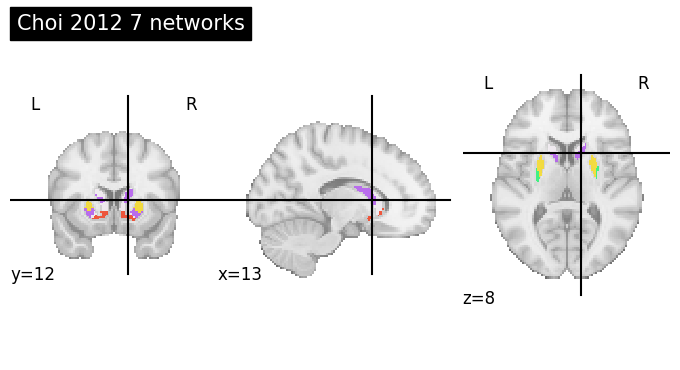

In [2]:
# Load parcellation given the mask file or voxel indices
parcel_mni = nb.load('../parcellations/volume_striatum/masked_par_choi_7.nii.gz').get_fdata()
coord = np.unravel_index(vol_ind - 1, parcel_mni.shape, 'F')  # Note: the linear indexing in numpy is column-order
parcels = np.rint(parcel_mni[coord[0], coord[1], coord[2]])
print(parcels)

# Visualizing the parcellation in volume space
%matplotlib inline
import nilearn as nl
from nilearn import plotting
plotting.plot_roi(nl.image.load_img('../parcellations/volume_striatum/masked_par_choi_7.nii.gz'),title='Choi 2012 7 networks')
plotting.show()

Above plot shows the `Choi 7` parcellation in volume space. To evaluate it, we also need a pairwise distance matrix of all mask voxel indices aligned to this volume space template.

In [3]:
# Compute the distance matrix between voxel pairs using the mask file, numpy default C-order
coord = np.asarray(coord).transpose()
dist = compute_dist(coord, 2, backend='numpy')
print(dist.shape)

(4135, 4135)


Here, we load subject functional data for DCBC evaluation and several experiment settings.

In [4]:
# Load functional profile (betas) and several parameters for evaluation settings
T = mat73.loadmat('../data/striatum_avrgDataStruct.mat')['T']
returnsubj = [2,3,4,6,8,9,10,12,14,15,17,18,19,20,21,22,24,25,26,27,28,29,30,31]
session, maxDist, binWidth = 1, 90, 5

Now, we start the real DCBC evaluation on the given parcellation using selected subjects and given experiment settings. So here we set the bin width = 5 mm, the maximum distance between any pair of voxels is 90 mm. We only use subjects session 1 data.

In [5]:
wcorr_array, bcorr_array, dcbc_array = np.array([]), np.array([]), np.array([])
for sub in returnsubj:
    print(f'Evaluating subject {sub} ...')
    data = T['data'][(T['SN'] == sub) & (T['sess'] == session)].T
    R = compute_DCBC(maxDist=maxDist, func=data, dist=dist, binWidth=binWidth, parcellation=parcels, backend='numpy')
    wcorr_array = np.append(wcorr_array, R['corr_within'])
    bcorr_array = np.append(bcorr_array, R['corr_between'])
    dcbc_array = np.append(dcbc_array, R['DCBC'])

# print(wcorr_array, bcorr_array, dcbc_array)

Evaluating subject 2 ...
Evaluating subject 3 ...
Evaluating subject 4 ...
Evaluating subject 6 ...
Evaluating subject 8 ...
Evaluating subject 9 ...
Evaluating subject 10 ...
Evaluating subject 12 ...
Evaluating subject 14 ...
Evaluating subject 15 ...
Evaluating subject 17 ...
Evaluating subject 18 ...
Evaluating subject 19 ...
Evaluating subject 20 ...
Evaluating subject 21 ...
Evaluating subject 22 ...
Evaluating subject 24 ...
Evaluating subject 25 ...
Evaluating subject 26 ...
Evaluating subject 27 ...
Evaluating subject 28 ...
Evaluating subject 29 ...
Evaluating subject 30 ...
Evaluating subject 31 ...


After we finished the DCBC evalaution for all subjects, we plot the un-weighted within- and between-correlation curves. A bigger gap between two curves means the given parcellation has higher quality to functionally separate the brain regions. Otherwise, the parcellation cannot functionally separate the brain obviously. In the extrame, the two curves are the same for random parcellations.

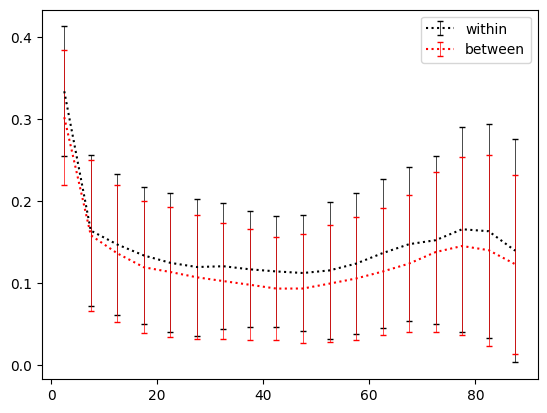

[0.01703593 0.0327379  0.00376956 0.01475464 0.00624606 0.00335091
 0.0275695  0.03244851 0.01709353 0.00131853 0.01773563 0.0115281
 0.00907436 0.04684011 0.01246886 0.01042326 0.0126392  0.01273811
 0.05126503 0.00155614 0.01637881 0.01597363 0.01455931 0.00617436]


In [6]:
%matplotlib inline
plot_single(within=wcorr_array, between=bcorr_array, maxDist=90, binWidth=5,
                subjects=returnsubj, within_color='k', between_color='r')
print(dcbc_array)